In [2]:
import numpy as np
from scipy import sparse
from sklearn import svm
import pandas as pd
import pickle
from keras.layers import Dense
from keras.models import Sequential
import keras
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils import to_categorical
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import KFold, cross_val_score

from keras.models import Sequential

from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

Using TensorFlow backend.


In [5]:
inspire = pd.read_pickle('REFS')
inspire = inspire.reset_index(drop=True)
inspire.head()

,Text,Title-sing,Title-bi,Title-tri,Title-quad,Abs-sing,Abs-bi,Abs-tri,Abs-quad,core refs,non-core refs,Result
0,Mott Quantum Criticality in the Anisotropic 2D...,0,0,0,0,9,0,0,0,0.00000,0.50000,0
1,Balanced Reed-Solomon Codes We consider the pr...,0,0,0,0,11,1,0,0,0.00000,0.00000,0
2,Fermion Dipole Moment and Holography In the ba...,0,0,0,0,9,2,0,0,0.93617,0.00000,2
3,Quantization conditions and functional equatio...,0,0,0,0,9,1,0,0,0.92500,0.02500,2
4,"Resonances in the continuum, field induced non...",2,0,0,0,6,0,0,0,0.00000,0.04386,0


In [6]:
# tokenise text for later
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(inspire['Text'])
sequences = tokenizer.texts_to_sequences(inspire['Text'])
data = pad_sequences(sequences, maxlen=500)

In [7]:
# SPLIT DATA INTO TRAIN/ TEST
training_samples = 3 * len(inspire) // 5
validation_samples = len(inspire) // 5

train = data[:training_samples]
val = data[training_samples:training_samples + validation_samples]
test = data[training_samples + validation_samples:]

inspire_train = inspire[:training_samples]
inspire_val = inspire[training_samples:training_samples + validation_samples].reset_index(drop=True)
inspire_test = inspire[training_samples + validation_samples:].reset_index(drop=True)

In [8]:
# FIND WEIGHTS FOR LATER
N_core =    len( inspire_train['Result'][ inspire_train['Result'] == 2 ] )
N_noncore = len( inspire_train['Result'][ inspire_train['Result'] == 1 ] )
N_rej  =    len( inspire_train['Result'][ inspire_train['Result'] == 0 ] )

print (N_core, N_noncore, N_rej)

N_total = float(len(inspire_train['Result']))
weights = {0: N_total/(N_core),
          1: N_total/(N_noncore),
           
          2: N_total/(N_rej)}
print (weights)

(3522, 2017, 17725)
{0: 6.6053378762067005, 1: 11.533961328705999, 2: 1.3124964739069112}


## net 

here, I want to make a neurel net, train it for the text, syphon of the auxiliary layer and put it into an SVM with the reference data

In [9]:
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model

main_input = Input(shape=(500,), dtype='float', name='main_input')
x = Embedding(output_dim=100, input_dim=10000, input_length = 500)(main_input)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dense(32, activation='relu')(x)
auxiliary_output = Dense(32, activation='sigmoid', name='aux_output')(x)

main_output = Dense(3, activation='softmax', name='main_output')(x)

model = Model(inputs=[main_input], outputs=[main_output, auxiliary_output])
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [10]:
history = model.fit({'main_input': train}, 
                    {'main_output': inspire_train['Result'], 'aux_output': inspire_train['Result']}, 
                    epochs=7, batch_size=300, class_weight=weights,
                    validation_data=({'main_input':val},
                                     {'main_output': inspire_val['Result'],'aux_output': inspire_val['Result']}))

Train on 23264 samples, validate on 7754 samples
Epoch 1/7
23264/23264 [==============================] - 10s 415us/step - loss: 2.2342 - main_output_loss: 0.6720 - aux_output_loss: 1.5622 - main_output_acc: 0.7671 - aux_output_acc: 0.7420 - val_loss: 1.2446 - val_main_output_loss: 0.5680 - val_aux_output_loss: 0.6766 - val_main_output_acc: 0.7596 - val_aux_output_acc: 0.7564
Epoch 2/7
23264/23264 [==============================] - 9s 389us/step - loss: 0.8560 - main_output_loss: 0.3595 - aux_output_loss: 0.4965 - main_output_acc: 0.8750 - aux_output_acc: 0.7689 - val_loss: 0.7147 - val_main_output_loss: 0.2981 - val_aux_output_loss: 0.4166 - val_main_output_acc: 0.9017 - val_aux_output_acc: 0.8258
Epoch 3/7
23264/23264 [==============================] - 9s 396us/step - loss: 0.5241 - main_output_loss: 0.2410 - aux_output_loss: 0.2831 - main_output_acc: 0.9148 - aux_output_acc: 0.8995 - val_loss: 0.5328 - val_main_output_loss: 0.2625 - val_aux_output_loss: 0.2703 - val_main_output_acc:

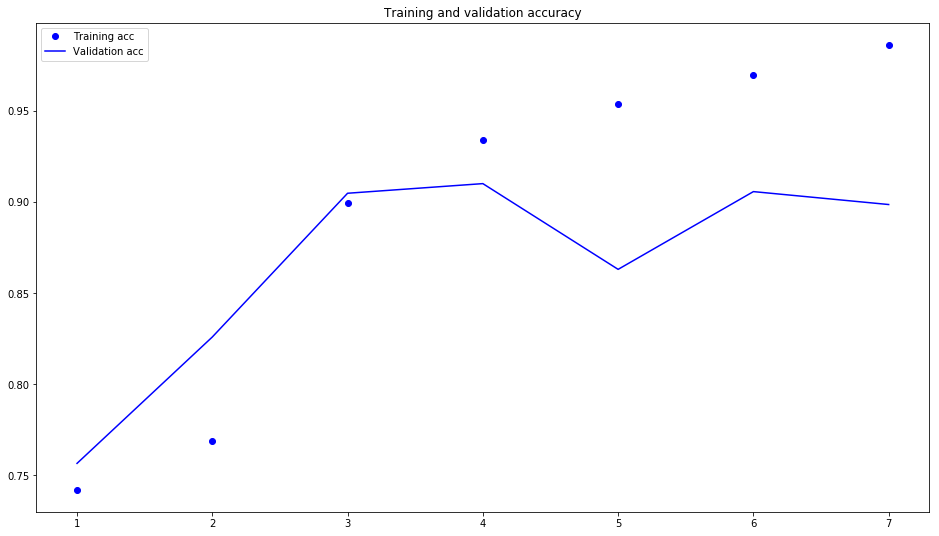

In [12]:
acc = history.history['aux_output_acc']
val_acc = history.history['val_aux_output_acc']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(16, 9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

Now, we can take the auxiliary data and play with it. Theres 16 columns, thats quite a lot, maybe do PCA with it?

In [13]:
# put training/ val through model
Ptrain = model.predict(train)
Pvec = model.predict(val)
# take just the aux stuff
T = Ptrain[1]
V = Pvec[1]
# lets try reduce dimensionality
from sklearn.decomposition import PCA
pca = PCA(.99999)
pca.fit(T)
pca.n_components_

3

In [14]:
# do the transform: 32 -> 3
Ptr = pca.transform(T)
Pv = pca.transform(V)

In [15]:
#check to see if its all good
svc = svm.SVC(decision_function_shape='ovo', kernel='linear',probability=True)
SVC = svc.fit(Ptr, inspire_train['Result'])

print SVC.score(Pv, inspire_val['Result'])

0.898375032241


build a new df

In [16]:
#put the 3 PC columns into original df's
PCA_ = ['PC1', 'PC2', 'PC3']
training = pd.DataFrame(Ptr, columns=PCA_)
inspire_train = pd.concat([inspire_train, training], axis = 1)

vali = pd.DataFrame(Pv, columns=PCA_)
inspire_val   = pd.concat([inspire_val, vali], axis = 1)

## SVM 

In [17]:
# quick check of quality
inputs = ['Title-sing', 'Title-bi', 'Title-tri', 'Title-quad', 'Abs-sing','Abs-bi', 'Abs-tri', 'Abs-quad','core refs', 'non-core refs', 'PC1', 'PC2', 'PC3']
svc = svm.SVC(decision_function_shape='ovo', kernel='linear', C=615, probability=True)
SVC = svc.fit(inspire_train[inputs], inspire_train['Result'])
print SVC.score(inspire_val[inputs], inspire_val['Result'])

0.911400567449


In [52]:
dec = svc.decision_function(inspire_val[inputs])
print dec

[[  0.79   3.81   1.7 ]
 [  1.41   1.7    0.04]
 [ 14.58  12.91   1.36]
 ..., 
 [ 28.21  24.35   1.9 ]
 [  7.38   6.47  -0.07]
 [  0.49   1.67  -0.09]]


In [29]:
class_probabilities = svc.predict_proba(inspire_val[inputs])
print class_probabilities[7735]

[ 0.97  0.02  0.01]


scores

In [20]:
X = inspire_train[inputs]
y = inspire_train['Result']

#svc = svm.SVC(kernel='linear')
#svc = svm.SVC(decision_function_shape='ovo')

C_s = np.logspace(-1, 3, 20)

scores = list()
scores_std = list()
for C in C_s:
    svc.C = C
    this_scores = cross_val_score(svc, X, y, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

# Do the plotting
import matplotlib.pyplot as plt
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.semilogx(C_s, scores)
plt.semilogx(C_s, np.array(scores) + np.array(scores_std), 'b--')
plt.semilogx(C_s, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter C')
plt.ylim(0.7, 1 )
plt.show()

KeyboardInterrupt: 

In [34]:
from sklearn.model_selection import GridSearchCV, cross_val_score
Cs = np.logspace(-1, 3, 20)
clf = GridSearchCV(estimator=svc, param_grid=dict(C=Cs), n_jobs=-1)

clf.fit(inspire_train[inputs], inspire_train['Result']) 

print clf.best_score_ 
print clf.best_estimator_.C  

KeyboardInterrupt: 

Confusion Matrix

0.911400567449
Normalized confusion matrix
[[ 0.98  0.02  0.01]
 [ 0.45  0.45  0.1 ]
 [ 0.08  0.06  0.85]]


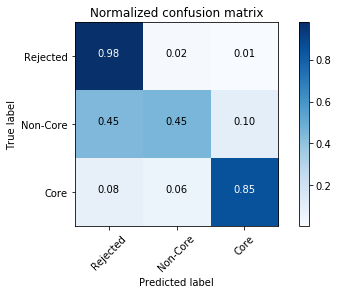

In [53]:
class_names = ["Rejected", "Non-Core", "Core"]

X_test = inspire_val[inputs]
y_test = inspire_val['Result']

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
# classifier = svm.SVC(decision_function_shape='ovo', C=clf.best_estimator_.C)

#classifier = svm.SVC(decision_function_shape='ovo', class_weight='balanced', C=1)
y_pred = svc.predict(X_test)
print SVC.score(X_test, y_test)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Look for wrongly labelled Non-core things

In [226]:
print y_pred.shape

y_pred.reshape(7754,1)
inspire_val['y_pred'] = y_pred

A1 = inspire_val.loc[(inspire_val['Result'] ==1) ]   #truly non-core
wrong_NC = A1.loc[(A1['y_pred'] == 0)]               #predicts Rejected

(7754,)


In [227]:
print class_probabilities[7704]

[ 0.97  0.02  0.01]


In [228]:
col = ['Text', 'Result', 'y_pred']
wrong_NC = wrong_NC[col]
wrong_NC.reset_index(drop=True)['Text']    
#wrong_NC['Text'][26]

0      Gromov-Witten/Pairs correspondence for the qui...
1      A note on proper affine symmetry in Kantowski-...
2      Gauged Hamiltonian Floer homology I: definitio...
3      Floer Field Philosophy Floer field theory is a...
4      On the stable Conley index in Hilbert spaces I...
5      PALS investigations of free volumes thermal ex...
6      40 years of the Nobel prize in physics: then a...
7      Detection of phase transition in generalized P...
8      Exact phase space matching for staging plasma ...
9      Curvature of fluctuation geometry and its impl...
10     The X-ray luminosity function of low mass X-ra...
11     Solvability and nilpotency for algebraic super...
12     Finite-order correlation length for 4-dimensio...
13     Half-quantized Non-Abelian Vortices in Neutron...
14     Quantum simulation of exotic PT-invariant topo...
15     Effects of anisotropic thermal conduction on w...
16     Discovery of a Highly Polarized Optical Microf...
17     Planetary nebulae: abund

In [184]:
# tokenise the words, try find the most "non-core-y" ones
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

lectures = wrong_NC['Text']
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(lectures)

indices = np.argsort(vectorizer.idf_)[::-1]
features = vectorizer.get_feature_names()

top_n = 1750
top_features = [features[i] for i in indices[:top_n]]
print top_features

[u'zsun', u'minute', u'mk', u'mjy', u'mj', u'cme', u'mix', u'mistake', u'misleading', u'misconception', u'mirrors', u'miras', u'mira', u'minutes', u'minor', u'mn', u'cns', u'cnss', u'minimize', u'minimality', u'co2', u'minihalo', u'miniaturized', u'mineralogy', u'min', u'mimic', u'milne', u'millions', u'cmb', u'clutter', u'millimeters', u'climatologist', u'month', u'clean', u'monoxide', u'monotone', u'monopnictides', u'monogamy', u'monochromatic', u'monitored', u'clearer', u'clifford', u'climate', u'climatological', u'molaro', u'mobius', u'cline', u'clock', u'modifcation', u'clockwise', u'moderately', u'closer', u'closure', u'cloud', u'modelled', u'clues', u'modal', u'mock', u'millimetre', u'millimeter', u'probes', u'mentioned', u'mets', u'cobe', u'methane', u'codata', u'coexist', u'metallic', u'messages', u'cohomological', u'merged', u'mere', u'mercury', u'mercator', u'mention', u'mf', u'coincidence', u'member', u'mele', u'meissner', u'meets', u'meet', u'coincident', u'medication', u'

In [217]:
# words that are in new dictionary and in a specific text
list( set(top_features).intersection( set(wrong_NC.reset_index(drop=True)['Text'][123].split(' ')) ) )

['look']

In [190]:
#load up the original dictionary
keysfile = np.loadtxt("KeyWords.csv", dtype="str") # load the keywords.
keywords = [word.lower() for word in keysfile]     # lowercase them all.

In [192]:
#how many words in original dictionary and "new dictionary"
len(list( set(top_features).intersection( set(keywords)) ) )

77